In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import os

sns.set_style('dark')

BA = 'SWPP'
FILE = f"{BA}.csv"
DIRI = "data"
MIN_K = 3
MAX_K = 25 # Assigned because of practicality

if not os.path.exists(f'silhouette_graphs/{BA}'):
    os.mkdir(f'silhouette_graphs/{BA}')

c:\Users\jimpg\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

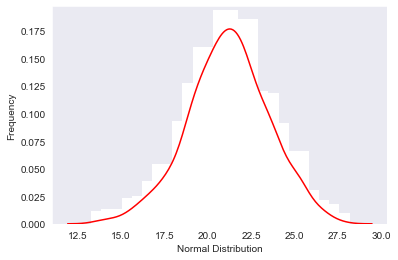

In [2]:
import scipy.stats as stats
import seaborn as sns
import numpy as np

peaks = [21, 22, 20, 18, 25]

data = stats.norm(loc=np.mean(peaks), scale=np.std(peaks)).rvs(1000)

ax = sns.distplot(data,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

In [3]:
file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [4]:
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW)
0,2015-07-02 00:00:00,39918,OKAY,39918,39490
1,2015-07-02 01:00:00,38696,OKAY,38696,38445
2,2015-07-02 02:00:00,37245,OKAY,37245,36878
3,2015-07-02 03:00:00,36321,OKAY,36321,36048
4,2015-07-02 04:00:00,34084,OKAY,34084,33685
...,...,...,...,...,...
43843,2020-07-01 19:00:00,43462,OKAY,43462,46972
43844,2020-07-01 20:00:00,44780,OKAY,44780,48118
43845,2020-07-01 21:00:00,45884,OKAY,45884,49210
43846,2020-07-01 22:00:00,45970,OKAY,45970,50225


In [5]:
# Convert the date string to a pandas datetime
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date  # Add separate date string 
df["hour"] = df["date_time"].dt.hour  # Add separate hour string
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW),date,hour
0,2015-07-02 00:00:00,39918,OKAY,39918,39490,2015-07-02,0
1,2015-07-02 01:00:00,38696,OKAY,38696,38445,2015-07-02,1
2,2015-07-02 02:00:00,37245,OKAY,37245,36878,2015-07-02,2
3,2015-07-02 03:00:00,36321,OKAY,36321,36048,2015-07-02,3
4,2015-07-02 04:00:00,34084,OKAY,34084,33685,2015-07-02,4
...,...,...,...,...,...,...,...
43843,2020-07-01 19:00:00,43462,OKAY,43462,46972,2020-07-01,19
43844,2020-07-01 20:00:00,44780,OKAY,44780,48118,2020-07-01,20
43845,2020-07-01 21:00:00,45884,OKAY,45884,49210,2020-07-01,21
43846,2020-07-01 22:00:00,45970,OKAY,45970,50225,2020-07-01,22


In [6]:
# Drop all columns except "Cleaned Demand (MW)"
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_demand = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_demand

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,39918,38696,37245,36321,34084,31400,29231,27588,26475,25734,...,29550,30914,32262,33460,34506,35392,35700,35924,35857,35173
2015-07-03,34183,33056,32028,31239,29540,27443,25607,24347,23531,22982,...,25348,27052,28623,30127,31500,32735,33544,34276,34711,34536
2015-07-04,33621,32372,30929,30108,28531,26750,24978,23577,22605,22039,...,23550,25600,27701,29587,31153,32376,33303,33999,34146,33748
2015-07-05,32812,31523,29984,28840,27697,26707,25312,24017,23042,22437,...,24521,26830,29143,31227,33224,34951,36353,37428,38186,38428
2015-07-06,37835,36563,35184,34516,32508,30043,28090,26756,25827,25268,...,29917,31798,33792,35473,36914,38170,38739,38938,38485,37233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,42505,41224,39479,38369,36490,34460,32066,30393,29075,27959,...,28952,30619,32575,34442,35972,37347,38517,39569,40408,40839
2020-06-28,40611,39436,37843,36856,35159,33086,31124,29684,28640,27901,...,29270,31580,34015,36206,38153,39680,40692,41361,41725,41735
2020-06-29,41041,40008,38767,38025,36314,33980,32038,30703,29689,29083,...,34115,35847,37726,39384,40897,42205,43198,44049,44614,44616


<AxesSubplot:>

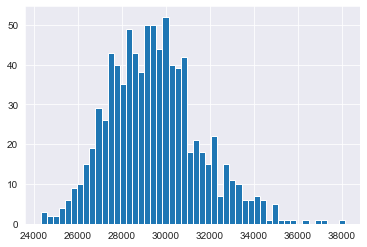

In [18]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

cluster = df_demand.loc[df_demand['profile_cluster'] == 1]
peaks = cluster.max(axis=1)
peaks.hist(bins=50)

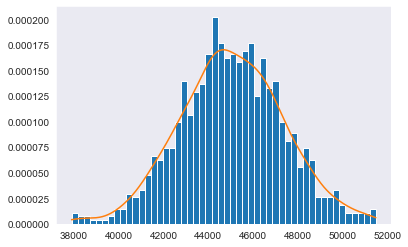

In [19]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(data)
x = np.linspace(np.min(data), np.max(data), 1000)

plt.hist(data, bins=50, density=True, label='histogram')

plt.plot(x, kde.pdf(x), label='kde')

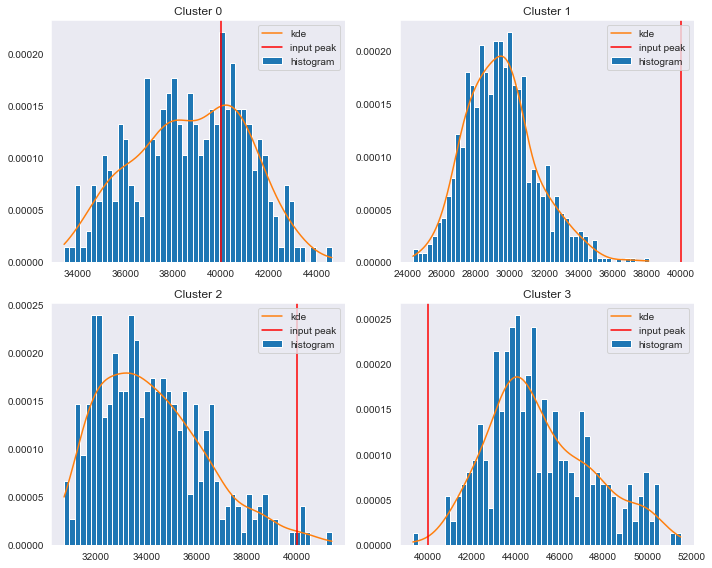

In [32]:
#  If a peak demand value was eg. 40000

kmeans = KMeans(n_clusters=4, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

input_peak = 40000

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
# plt.figure(figsize=(30, 20))

for k in range(4):

    cluster = df_demand.loc[df_demand['profile_cluster'] == k]
    peaks = cluster.max(axis=1)
    ax[k//2, k%2].hist(peaks, bins=50, density=True, label='histogram')
    x = np.linspace(np.min(peaks), np.max(peaks), 1000)
    kde = gaussian_kde(peaks)
    ax[k//2, k%2].plot(x, kde.pdf(x), label='kde')
    ax[k//2, k%2].axvline(x=input_peak, color='red', label='input peak')
    ax[k//2, k%2].legend(loc='upper right')
    ax[k//2, k%2].set_title(f'Cluster {k}')

fig.tight_layout()

In [10]:
# Save cluster magnitudes (sum of sqaured distances to the centroid) in a dataframe
# where index = number of clusters

# .inertia_ returns the sum of squared distances of samples to their closest cluster center
# .cluster_centers_  returns array wuth coordinates of cluster centers
# .labels_ returns the cluster label of each example in order

from random import randint

num_iter = 10

columns = []
for idx in range(num_iter):
    columns.append(f'Silhouette_{idx}')
    columns.append(f'DB_{idx}')

cluster_stats = pd.DataFrame(index=range(MIN_K, MAX_K), columns=columns)

# should test with multiple random states
for k in cluster_stats.index: # number of clusters
    for idx in range(num_iter): # iteration number
        kmeans = KMeans(n_clusters=k, random_state=randint(0, 1000)).fit(df_demand)
        clusters = kmeans.labels_
        
        # For each cluster label, find how many examples are part of that cluster
        cluster_sizes = []
        for i in range(k):
            cluster_sizes.append(len(np.where(clusters == i)[0]))

        # Calculate the average Silhouette Score for each cluster
        cluster_stats[f'Silhouette_{idx}'][k] = silhouette_score(df_demand, kmeans.labels_)

        # Davies Boulding score
        cluster_stats[f'DB_{idx}'][k] = davies_bouldin_score(df_demand, kmeans.labels_)
        
        # print("\nk = ", k,
        # "\nMagnitude = ", kmeans.inertia_,
        # "\nSizes = ", cluster_sizes, 
        # "\nSilhouetten Score = ", cluster_stats['Silhouette'][k], 
        # "\nDavies-Bouldin Score = ", cluster_stats['DB'][k])
        
for idx in range(num_iter):
    plt.plot(cluster_stats[f'DB_{idx}'], label=f'{idx}')

    # ax.set_title("KMeans Results")
    # ax.plot(cluster_stats['Silhouette'], color='blue', label='Silhouette Score')
    # ax.set_xlabel("k (number clusters)")
    # ax.set_ylabel("Silhouette Score")

    # ax2 = ax.twinx()
    # ax2.plot(cluster_stats['DB'], color='green', label='Davies-Bouldin Score')
    # ax2.set_ylabel('Davies Bouldin')

    # ax.axvline(x=MIN_K+np.argmin(cluster_stats['DB']), linestyle='--')
    # ax2.text(MIN_K+np.argmin(cluster_stats['DB'])-1,
    # np.min(cluster_stats['DB']),
    # f"K={MIN_K+np.argmin(cluster_stats['DB'])}", 
    # fontsize=25)

plt.legend()

plt.savefig(f"silhouette_graphs/{BA}/kmeans_results", facecolor='white', transparent=False)

cluster_stats.to_csv(f"kmeans_results")

KeyboardInterrupt: 

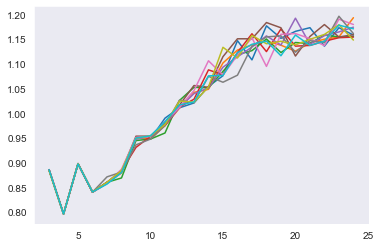

In [ ]:
for idx in range(num_iter):
    plt.plot(cluster_stats[f'DB_{idx}'], label=f'{idx}')

C:\Users\jimpg\AppData\Local\Temp/ipykernel_19600/432582791.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_silho = pd.Series(index=range(3, MAX_K))


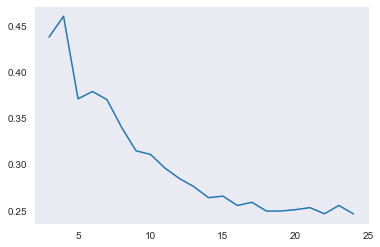

In [ ]:
# Perform silhouette analysis on a point-by-point basis
avg_silho = pd.Series(index=range(3, MAX_K))

for k in range(3, MAX_K):
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df_demand)

    silhouette_avg = silhouette_score(df_demand, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_demand, cluster_labels)

    avg_silho[k] = silhouette_avg

    y_lower = 10
    for i in range(k): # for each cluster created
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


    plt.title(f"Silhouette Coefficients for All Points, k={k}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.savefig(f"silhouette_graphs/{BA}/kmeans_silhouette_{k}.png", facecolor='white', transparent=False)
    plt.close()

plt.plot(avg_silho)

In [ ]:
cluster_stats

,Silhouette_0,DB_0,Silhouette_1,DB_1,Silhouette_2,DB_2,Silhouette_3,DB_3,Silhouette_4,DB_4,Silhouette_5,DB_5,Silhouette_6,DB_6,Silhouette_7,DB_7,Silhouette_8,DB_8,Silhouette_9,DB_9
3,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.437729,0.885541,0.43933,0.883401,0.437729,0.885541
4,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001,0.460405,0.796001
5,0.370872,0.897892,0.370864,0.897171,0.370864,0.897171,0.370826,0.897255,0.370864,0.897171,0.370872,0.897892,0.370733,0.898184,0.370936,0.897735,0.370936,0.897735,0.370864,0.897171
6,0.378758,0.84026,0.378858,0.840161,0.378858,0.840161,0.379124,0.839935,0.378952,0.840294,0.378759,0.840475,0.378858,0.840161,0.379027,0.840195,0.378759,0.840475,0.378759,0.840475
7,0.369912,0.86002,0.369912,0.86002,0.369912,0.86002,0.369459,0.85853,0.369484,0.857642,0.369912,0.86002,0.369564,0.858607,0.367037,0.871063,0.369912,0.86002,0.369639,0.856484
8,0.341246,0.882623,0.342834,0.878657,0.348041,0.86888,0.340635,0.88375,0.341802,0.880734,0.341246,0.882623,0.339106,0.886413,0.341802,0.880734,0.340638,0.883892,0.342444,0.87968
9,0.314211,0.94963,0.313618,0.949827,0.314573,0.944617,0.317156,0.930775,0.314522,0.947152,0.312322,0.953448,0.313335,0.951043,0.315826,0.935932,0.314311,0.949101,0.314211,0.94963
10,0.309274,0.947644,0.309318,0.947699,0.309274,0.947644,0.308306,0.953273,0.308306,0.953273,0.308337,0.953519,0.308306,0.953273,0.309303,0.947571,0.308554,0.954226,0.308064,0.954302
11,0.293601,0.989958,0.296287,0.974833,0.298899,0.959912,0.295961,0.974971,0.296264,0.976964,0.295505,0.979652,0.293685,0.983143,0.296218,0.975009,0.296389,0.977113,0.294466,0.982736
12,0.284376,1.010887,0.284452,1.010249,0.281396,1.025786,0.283976,1.01273,0.284291,1.011597,0.282488,1.016534,0.284075,1.012112,0.281346,1.026303,0.281507,1.024615,0.282588,1.016738


In [ ]:
for 

In [ ]:
from matplotlib.gridspec import GridSpec

chosen_k = cluster_stats.loc[cluster_stats['DB'] == cluster_stats['DB'].min()].index[0]

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

kmeans = KMeans(n_clusters=chosen_k, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

for k in range(chosen_k):
    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == k].reset_index()
    df_cluster_loads.drop("profile_cluster", axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax = fig.add_subplot(gs[k])
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[k][0:24], '.-', color='orange')

    ax.set_title(f'Number Profiles: {len(df_demand.loc[df_demand["profile_cluster"] == k])}')


fig.savefig(f'silhouette_graphs/{BA}/kmeans_{chosen_k}_load_profiles', facecolor='white', transparent=False)

KeyError: 'DB'

Let's figure out what kind of day each cluster represents.

In [ ]:
def is_weekday(x):
    if x < 5:
        return True
    else:
        return False
    
    
def season_name(x):
    if x == 1:
        return "Winter"
    if x == 2:
        return "Spring"
    if x == 3:
        return "Summer"
    if x == 4:
        return "Fall"

print('nO eRROS!~!')

nO eRROS!~!


In [ ]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
df_demand.index = pd.to_datetime(df_demand.index)

df_demand["weekday"] = df_demand.index.dayofweek
df_demand["season num"] = df_demand.index.month%12 // 3 + 1

df_demand["is weekday"] = df_demand["weekday"].apply(lambda x: is_weekday(x))
df_demand["season"] = df_demand["season num"].apply(lambda x: season_name(x))

df_clusters = df_demand[["profile_cluster", "is weekday", "season", "season num"]]
df_clusters.columns = ["profile_cluster", "is weekday", "season", "season num"]

for k in range(MAX_K):
    dfk = df_clusters.loc[df_clusters["profile_cluster"] == k]
    print(dfk.value_counts())

profile_cluster  is weekday  season  season num
0                True        Summer  3             210
                 False       Summer  3              59
                 True        Fall    4              26
                             Winter  1               5
                             Spring  2               4
                 False       Fall    4               2
dtype: int64
profile_cluster  is weekday  season  season num
1                True        Spring  2             279
                             Fall    4             198
                 False       Spring  2             122
                             Fall    4             101
                 True        Winter  1              85
                 False       Winter  1              64
                 True        Summer  3              10
                 False       Summer  3               6
dtype: int64
profile_cluster  is weekday  season  season num
2                True        Summer  3             109
     

In [ ]:
def cluster_similarity(x, centroid):
    # input is all rows belonging to a cluster
    total = 0
    
    for row in range(len(x)):
        for hour in range(23):
            # absolute diff between centroid hourly load and actual
            total += abs(x[hour][row] - centroid[hour])
    
    return total/len(x)

print('nO eRROS??')

nO eRROS??


In [ ]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_loads = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_loads["profile_cluster"] = clusters
df_loads

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,profile_cluster
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,39918,38696,37245,36321,34084,31400,29231,27588,26475,25734,...,30914,32262,33460,34506,35392,35700,35924,35857,35173,2
2015-07-03,34183,33056,32028,31239,29540,27443,25607,24347,23531,22982,...,27052,28623,30127,31500,32735,33544,34276,34711,34536,2
2015-07-04,33621,32372,30929,30108,28531,26750,24978,23577,22605,22039,...,25600,27701,29587,31153,32376,33303,33999,34146,33748,1
2015-07-05,32812,31523,29984,28840,27697,26707,25312,24017,23042,22437,...,26830,29143,31227,33224,34951,36353,37428,38186,38428,2
2015-07-06,37835,36563,35184,34516,32508,30043,28090,26756,25827,25268,...,31798,33792,35473,36914,38170,38739,38938,38485,37233,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,42505,41224,39479,38369,36490,34460,32066,30393,29075,27959,...,30619,32575,34442,35972,37347,38517,39569,40408,40839,0
2020-06-28,40611,39436,37843,36856,35159,33086,31124,29684,28640,27901,...,31580,34015,36206,38153,39680,40692,41361,41725,41735,0
2020-06-29,41041,40008,38767,38025,36314,33980,32038,30703,29689,29083,...,35847,37726,39384,40897,42205,43198,44049,44614,44616,0


In [ ]:
cluster_sims = []
for k in range(chosen_k):    
    input_x = df_loads.loc[kmeans.labels_ == k].reset_index()
    cluster_sims.append(cluster_similarity(input_x, centroids[k]))
    print(f"\nCluster {k}:", cluster_sims[k])


Cluster 0: 40503.70618138339

Cluster 1: 33446.508873667924

Cluster 2: 36087.5101497576

Cluster 3: 39117.942955836756


In [ ]:
df_clusters['year'] = df_clusters.index.year
df_clusters['day of year'] = df_clusters.index.dayofyear

dset = df_clusters.copy()
dset = dset.reset_index()
dset = dset.melt(id_vars=["year", "day of year"], value_vars='profile_cluster')

dset

C:\Users\jimpg\AppData\Local\Temp/ipykernel_21256/2624806095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['year'] = df_clusters.index.year
C:\Users\jimpg\AppData\Local\Temp/ipykernel_21256/2624806095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['day of year'] = df_clusters.index.dayofyear


,year,day of year,variable,value
0,2015,183,profile_cluster,2
1,2015,184,profile_cluster,2
2,2015,185,profile_cluster,1
3,2015,186,profile_cluster,2
4,2015,187,profile_cluster,2
...,...,...,...,...
1822,2020,179,profile_cluster,0
1823,2020,180,profile_cluster,0
1824,2020,181,profile_cluster,0
1825,2020,182,profile_cluster,0


In [ ]:
# dset used to represent cluster for everyday over dataset
dset.rename(columns = {"value":"cluster"}, inplace=True)
dset = dset.pivot(index="year", columns="day of year", values="cluster")
dset

day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,NaN
2016,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
2017,1.0,1.0,1.0,3.0,3.0,0.0,3.0,3.0,3.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN
2018,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,NaN
2019,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,...,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,NaN
2020,3.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
# NOTE: Monday = 0
def day_type_calc(season, weekday):
    # Weekdays
    if weekday:
        return season
    # Weekends
    else:
        return season + 4

print('nO eRRORS!')



nO eRRORS!


In [ ]:
df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4
df_clusters

C:\Users\jimpg\AppData\Local\Temp/ipykernel_21256/251835812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4


,profile_cluster,is weekday,season,season num,year,day of year,day type
date,,,,,,,
2015-07-02,2,True,Summer,3,2015,183,7
2015-07-03,2,True,Summer,3,2015,184,7
2015-07-04,1,False,Summer,3,2015,185,3
2015-07-05,2,False,Summer,3,2015,186,3
2015-07-06,2,True,Summer,3,2015,187,7
...,...,...,...,...,...,...,...
2020-06-27,0,False,Summer,3,2020,179,3
2020-06-28,0,False,Summer,3,2020,180,3
2020-06-29,0,True,Summer,3,2020,181,7


In [ ]:
df_clusters

,profile_cluster,is weekday,season,season num,year,day of year,day type
date,,,,,,,
2015-07-02,2,True,Summer,3,2015,183,7
2015-07-03,2,True,Summer,3,2015,184,7
2015-07-04,1,False,Summer,3,2015,185,3
2015-07-05,2,False,Summer,3,2015,186,3
2015-07-06,2,True,Summer,3,2015,187,7
...,...,...,...,...,...,...,...
2020-06-27,0,False,Summer,3,2020,179,3
2020-06-28,0,False,Summer,3,2020,180,3
2020-06-29,0,True,Summer,3,2020,181,7


day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,-1.0
2016,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,...,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0
2017,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,...,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,-1.0
2018,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,...,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,-1.0
2019,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,-1.0
2020,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


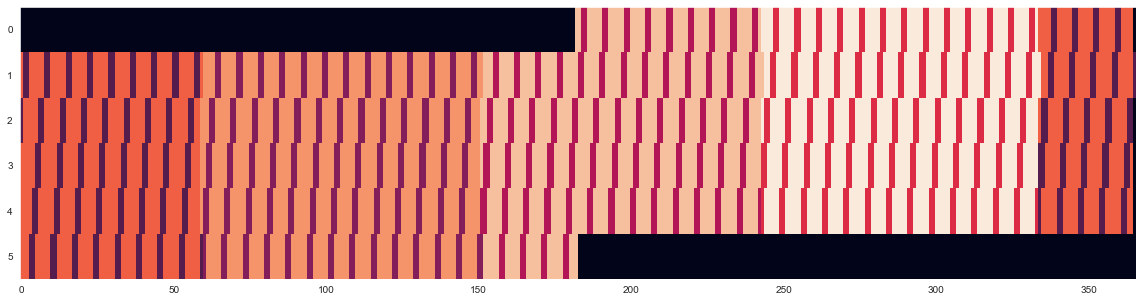

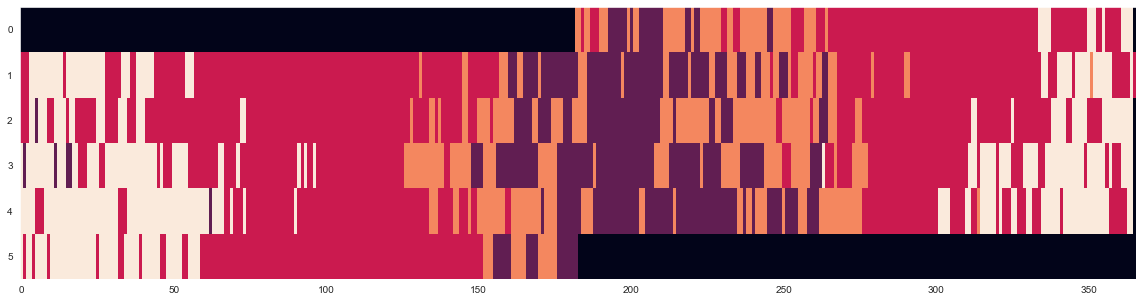

In [ ]:
day_type = df_clusters[["day type", "year", "day of year"]]
day_type = day_type.pivot(index = "year", columns = "day of year", values = "day type")
day_type.fillna(-1, inplace=True)

plt.figure(figsize=(20, 5))
plt.imshow(day_type, aspect='auto')

dset.fillna(-1, inplace=True)
plt.figure(figsize=(20, 5))
plt.imshow(dset, aspect='auto')
day_type

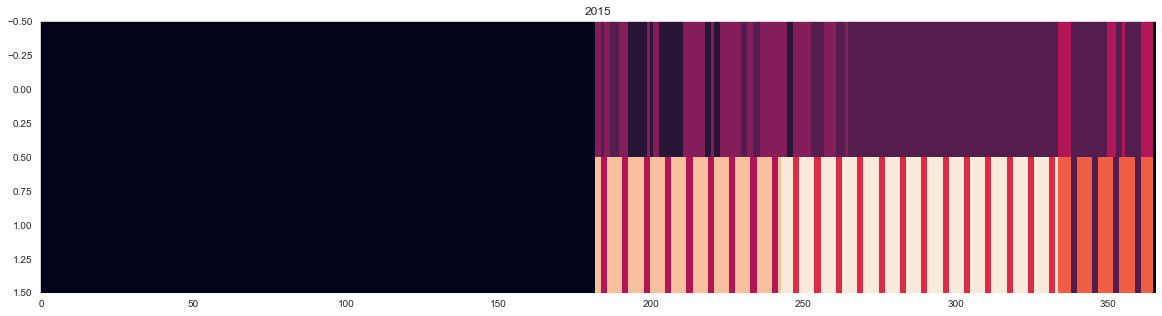

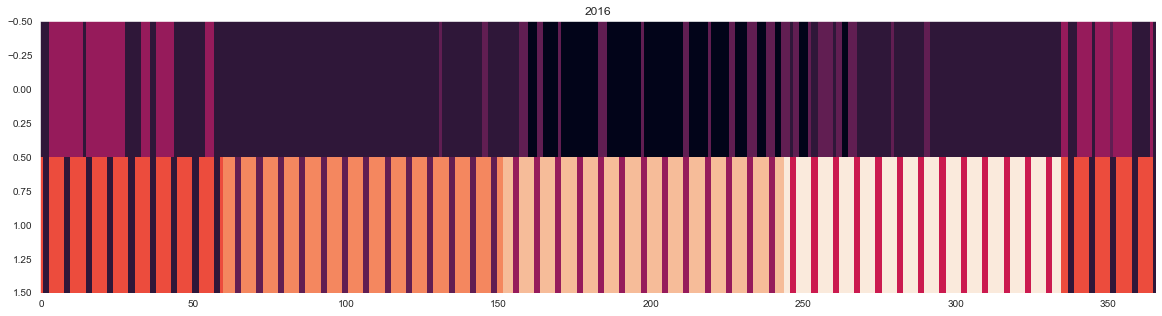

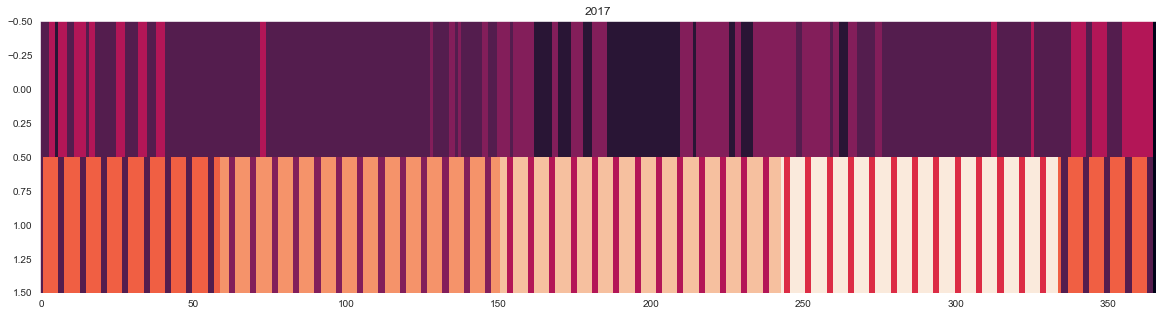

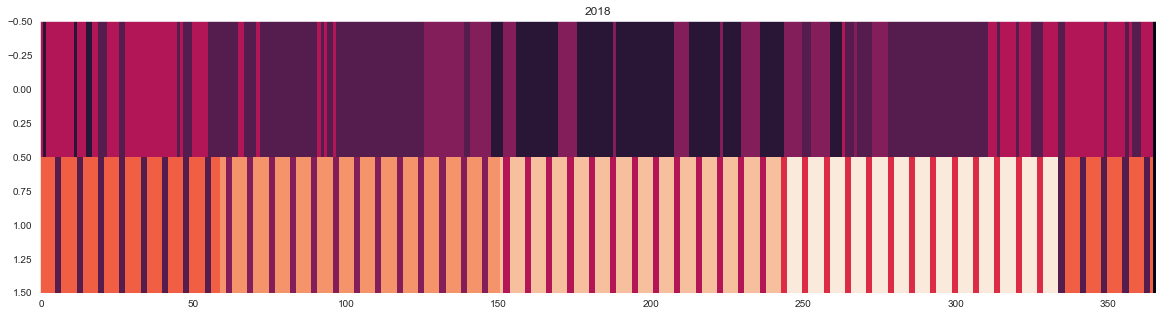

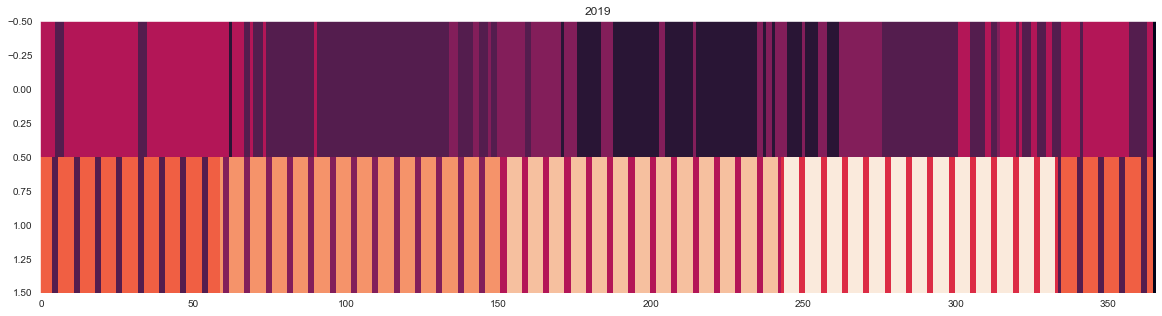

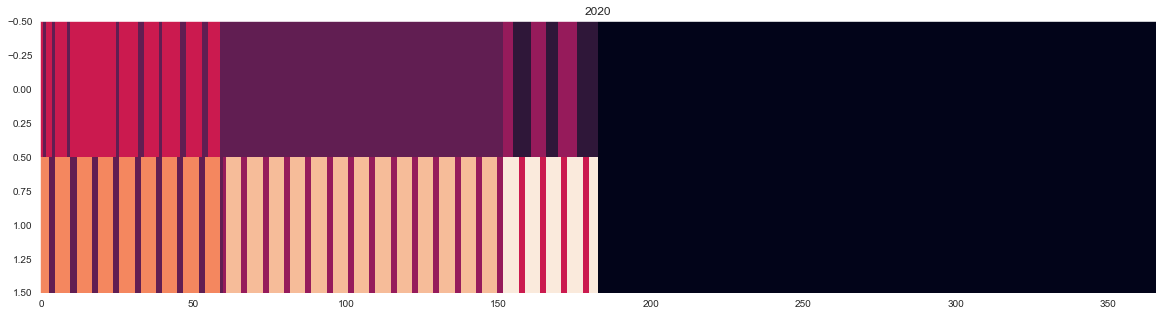

In [ ]:
for year in dset.index:
    dset_temp = dset.loc[dset.index == year].reset_index().drop('year', axis=1)
    dset_temp = dset_temp.append(day_type.loc[day_type.index == year].reset_index().drop('year', axis=1))
    plt.figure(figsize=(20, 5))
    plt.imshow(dset_temp, aspect='auto')
    plt.title(year)
    plt.savefig(f'silhouette_graphs/{BA}/spectrograph_{year}', facecolor='white', transparent=False)

In [ ]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
def reverse_day_type_calc(day_type):
    # Weekdays
    if day_type == 1:
        return 'Winter Weekday'
    if day_type == 2:
        return 'Spring Weekday'
    if day_type == 3:
        return 'Summer Weekday'
    if day_type == 4:
        return 'Fall Weekday'
    if day_type == 5:
        return 'Winter Weekend'
    if day_type == 6:
        return 'Spring Weekend'
    if day_type == 7:
        return 'Summer Weekend'
    if day_type == 8:
        return 'Fall Weekend'

print('nO eRRORS!')

nO eRRORS!


In [ ]:
cluster_spread = df_clusters.groupby(['day type'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

for i in range(1, 9):
    max_cluster = cluster_spread[['count', 'profile_cluster']].loc[cluster_spread['day type']  == i]
    max_cluster = max_cluster.loc[max_cluster['count'] == max_cluster['count'].max()]
    print(f"Most Frequent Cluster for {reverse_day_type_calc(i)}:", max_cluster['profile_cluster'].values)

Most Frequent Cluster for Winter Weekday: [3]
Most Frequent Cluster for Spring Weekday: [1]
Most Frequent Cluster for Summer Weekday: [2]
Most Frequent Cluster for Fall Weekday: [1]
Most Frequent Cluster for Winter Weekend: [3]
Most Frequent Cluster for Spring Weekend: [1]
Most Frequent Cluster for Summer Weekend: [0]
Most Frequent Cluster for Fall Weekend: [1]


In [ ]:
df_cluster_loads

,date,hour,value
0,2015-12-01,0,31418
1,2015-12-02,0,31162
2,2015-12-03,0,30638
3,2015-12-04,0,29550
4,2015-12-17,0,31354
...,...,...,...
8443,2020-02-22,23,26448
8444,2020-02-25,23,30861
8445,2020-02-26,23,30790
8446,2020-02-27,23,29215


Cluster 0


C:\Users\jimpg\AppData\Local\Temp/ipykernel_21256/479289648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['day name'] = df_clusters['day type'].map(reverse_day_type_calc)


Cluster 1
Cluster 2
Cluster 3


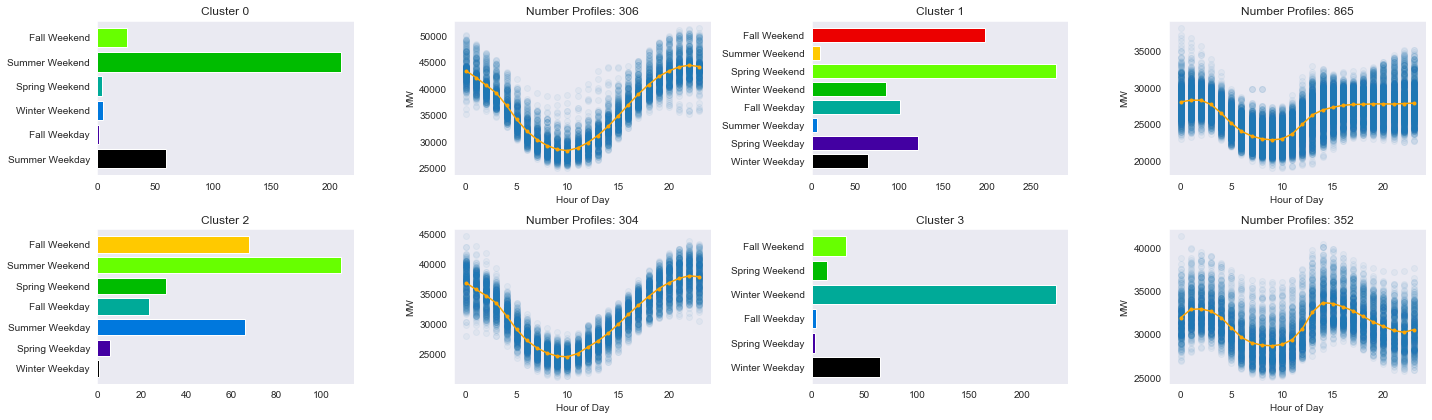

In [ ]:
df_clusters['day name'] = df_clusters['day type'].map(reverse_day_type_calc)
cluster_spread = df_clusters.groupby(['day type', 'day name'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)


for (graph_idx, cluster) in zip(range(0, chosen_k*2, 2), range(chosen_k)):
    max_cluster = cluster_spread[['day type', 'count', 'day name', 'profile_cluster']].loc[cluster_spread['profile_cluster']  == cluster]

    num_day_types = len(max_cluster['day name'].unique())
    color = cm.nipy_spectral(np.arange(8).astype(float)/8)

    ax = fig.add_subplot(gs[graph_idx])
    ax.barh(y=max_cluster['day name'], width=max_cluster['count'], color=color)
    ax.set_title(f'Cluster {cluster}')

    print(f'Cluster {cluster}')

    ax = fig.add_subplot(gs[graph_idx+1])

    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == cluster].reset_index()
    df_cluster_loads.drop(["profile_cluster", "weekday", "season num", "is weekday", "season"], axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[cluster][0:24], '.-', color='orange')
    ax.set_title(f'Number Profiles: {len(df_demand.loc[df_demand["profile_cluster"] == cluster])}')
    ax.set_ylabel('MW')
    ax.set_xlabel('Hour of Day')

fig.tight_layout()
fig.savefig(f'silhouette_graphs/{BA}/all_clusters_analysis', facecolor='white', transparent=False)

In [ ]:
df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == 1].reset_index()
df_cluster_loads


hour,date,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,profile_cluster,weekday,season num,is weekday,season
0,2015-07-04,33621,32372,30929,30108,28531,26750,24978,23577,22605,...,32376,33303,33999,34146,33748,1,5,3,False,Summer
1,2015-07-07,35807,34494,33454,32556,30440,28007,26040,24687,23786,...,30648,30690,30611,30358,29876,1,1,3,True,Summer
2,2015-07-08,29353,28786,28416,28273,26849,24993,23750,22795,22245,...,29832,30154,30347,30452,30270,1,2,3,True,Summer
3,2015-07-09,29860,29249,28801,28779,27329,25341,23831,22948,22351,...,32112,32708,33250,33477,33464,1,3,3,True,Summer
4,2015-08-19,36338,35189,34489,33204,30681,28211,26270,25043,24170,...,28995,29064,29245,29355,29306,1,2,3,True,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,2020-05-27,28813,28162,27647,27260,25851,24112,22884,22151,21626,...,29814,30248,30601,30639,30460,1,2,2,True,Spring
861,2020-05-28,30012,29201,28633,28197,26830,25062,23646,22733,22166,...,29680,30115,30539,30785,30628,1,3,2,True,Spring
862,2020-05-29,30327,29646,28869,28413,26932,25115,23627,22697,21945,...,30860,31595,32258,32726,32748,1,4,2,True,Spring
863,2020-05-30,32248,31127,29612,28834,27337,25456,23871,22772,22014,...,28956,29668,30370,30904,31204,1,5,2,False,Spring


In [ ]:
centroids

,0,1,2,3
0,43444.346405,28089.802312,36935.345395,31947.596591
1,42156.405229,28325.100578,35812.858553,32925.261364
2,40701.983660,28331.729480,34789.746711,32989.980114
3,39223.081699,27748.442775,33548.707237,32714.301136
4,36881.382353,26581.036994,31453.351974,31988.568182
5,34239.866013,25213.394220,29183.526316,30808.806818
6,32048.405229,24116.706358,27372.210526,29701.744318
7,30444.562092,23464.634682,26124.444079,29066.809659
8,29307.486928,23093.460116,25280.927632,28784.079545
9,28582.457516,22938.686705,24766.434211,28712.670455
